In [3]:
from files.utils.constants import *
from files.utils.utility_functions import *
from files.pif.pif import *
from files.classes.neural_models import *
from tqdm import tqdm
# import seaborn as sns

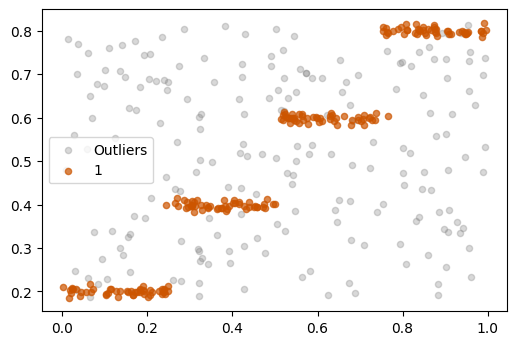

In [4]:
ds, gt = load_dataset_by_name("stair4", base_path="../../")
plot_clusters(clusters=gt, data=ds)

Epoch 100/100: [==============================] (100%) ETA: 0:00:00.002363 Mean Loss: 0.26111


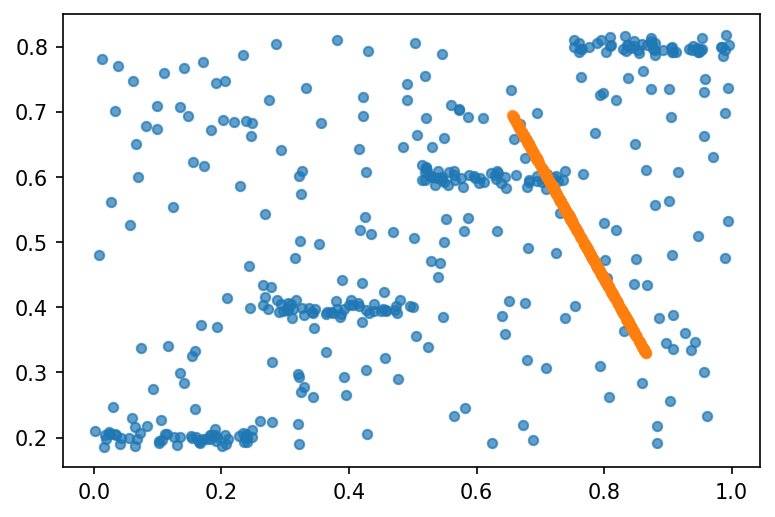

In [14]:
nn = NeuralNetwork(neurons=[2, 1, 2], activation=lambda x:x)
nn.fit(ds[np.random.randint(0, len(ds), 2)], epochs=100, print_training=True)
preds = nn.predict(ds)
plot(ds, new_fig=True)
plot(preds)

In [154]:
models = []
for i in tqdm(range(300)):
    ae = AEModel(n_first_hidden=0, activation=lambda x: x)
    ae.fit(data=ds[np.random.randint(0, len(ds), size=(2))], epochs=10, print_training=False);
    models.append(ae)

100%|██████████| 300/300 [00:01<00:00, 175.31it/s]


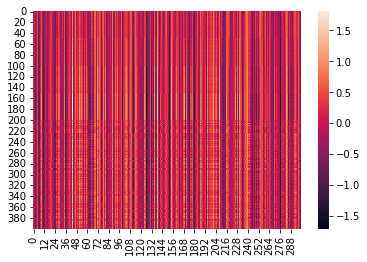

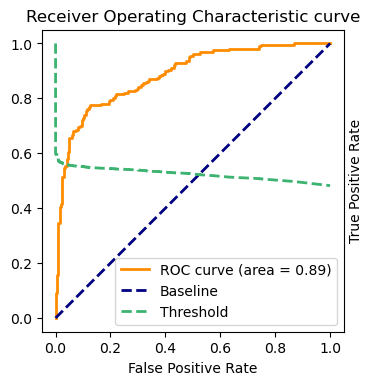

In [155]:
projs_mtrx = np.zeros(shape=(len(ds), len(models)))
for i, m in enumerate(models):
    projs_mtrx[:, i] = m.get_projections(ds).flatten()
sns.heatmap(projs_mtrx)
voronoi1 = VoronoiIForest(**ivor_parameters)
voronoi1.fit(data=projs_mtrx)
pro_scores = voronoi1.score_samples(projs_mtrx)
make_roc(gt, pro_scores);

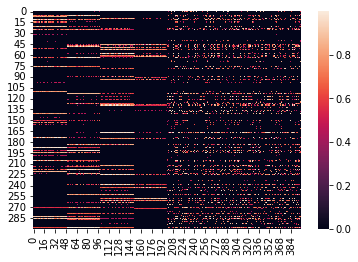

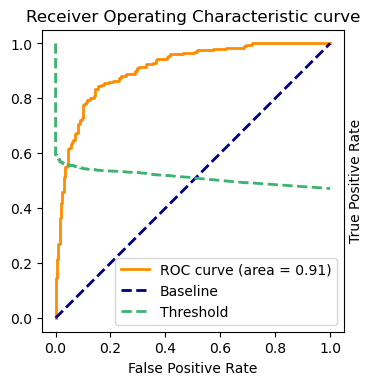

In [156]:
from files.pif.pif import *
#np.random.shuffle(ds)
prefs = build_preference_matrix(data=ds, models=models, threshold=0.1)
sns.heatmap(prefs.T)
voronoi2 = VoronoiIForest(**ivor_parameters)
voronoi2.fit(data=prefs)
pre_scores = voronoi2.score_samples(prefs)
make_roc(gt, pre_scores);

In [11]:
from files.utils.constants import *
from files.utils.utility_functions import *
from files.pif.pif import *
from files.classes.neural_models import *
from tqdm import tqdm
# import seaborn as sns

In [145]:
from files.utils.dataset_creator import *
ds, gt = create_dataset_line(num_points=200, m_s=[-0.856], q_s=[0.5], outliers_fraction=0, noise_var=0)
mss = ds#[np.random.randint(0, len(ds), 2)]
ae = NeuralNetwork(neurons=[2,1,2], activation=lambda x: x)
ae.fit(mss, 5000, print_training=True, lr=1e-2);

Epoch 5000/5000: [==============================] (100%) ETA: 0:00:00.015445 Mean Loss: 0.00033


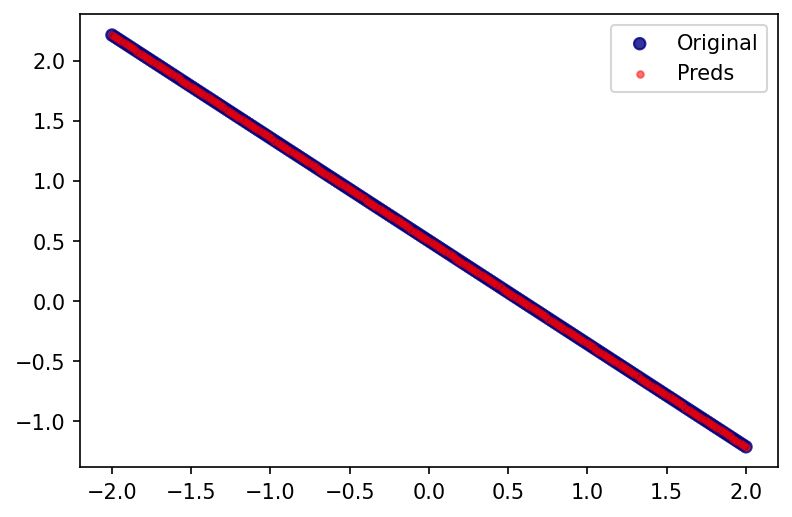

In [146]:
# ae.fit(mss, 5000, print_training=True, lr=1e-3);
preds = ae.predict(ds)
plot(ds, c=gt, cmap="jet", new_fig=True, alpha=0.8, s=30, label="Original")
plot(preds, label="Preds", s=10, alpha=0.5, c='r')
# plot(mss, label="mss", c='g')

In [153]:
layers = [l for l in ae.parameters()]
w1, w2 = layers[0][0].detach().numpy()
b0 = layers[1][0].item()
w3, w4 = layers[2][0][0].item(), layers[2][1][0].item()
b1, b2 = layers[3].detach().numpy()
w1, w2, b0, w3, w4, b1, b2

(-0.8032129,
 0.6225683,
 -0.027920693159103394,
 -0.7485254406929016,
 0.6407449245452881,
 0.21203592,
 0.3184847)

In [148]:
(w3, 1/w1), (b1, -b0/w1), (w4, 1/w2), (b2, -b0/w2)

((-0.7485254406929016, -1.2449999539911765),
 (0.21203592, -0.03476126169848548),
 (0.6407449245452881, 1.606249442913297),
 (0.3184847, 0.04484759783256293))

In [155]:
def predict(point):
    x1, x2 = point
    w1 = 1/w3
    
    h = w1*x1 + w2*x2 + b0
    # w3 = 1/w1
    # b1 = -b0/w1
    # b2 = -b0/w2
    # w4 = 1/w2
    xhat = w3*h + b1
    yhat = w4*h + b2
    return np.array([xhat, yhat])

In [156]:
preds = np.array([predict(p) for p in ds])

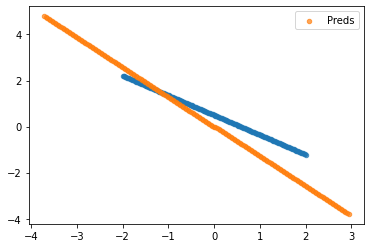

In [158]:
plot(ds)
plot(preds, label="Preds")

In [154]:
# m_s=[-0.856], q_s=[0.5]
idx = np.random.randint(0, len(ds))
x1, x2 = ds[idx]
h1 = w1*x1 + w2*x2 + b0

# w3 = 1/w1
# b1 = -b0/w1
# w4 = 1/w2
# b2 = -b0/w2

o1 = w3*h1 + b1
o2 = w4*h1 + b2
m_mio = w4 / w3
q_mio = b2 - m_mio*b1
m = (o2 - 0.5) / o1
q = o2 - m*o1
print("M mio == m?", m_mio == m, m_mio, m)
print("Q mio == q?", q_mio == q, q_mio, q)
print()
pred = ae.predict(ds[idx].reshape(1,-1))[0]
print("Point:", x1, x2)
print("Latent representation:", h1)
print("Network's slope:", m)
print("Network's intercept:", q)
print()
print("My output:", (o1, o2))
print("Network output:", pred)
print("MSE:", np.linalg.norm(pred - ds[idx]))

M mio == m? False -0.8560095485227031 -0.8560189873895788
Q mio == q? False 0.4999894695074606 0.5

Point: 1.1155778894472363 -0.45493467336683424
Latent representation: -1.207195134263542
Network's slope: -0.8560189873895788
Network's intercept: 0.5

My output: (1.1156521940731876, -0.4550194614494919)
Network output: [ 1.1156523  -0.45501956]
MSE: 0.0001129010333991061


In [138]:
x = -3
y = 5# 0.3*x + 1
r_y = 0.3*x + 1
pred = ae.predict(np.array([[x, y]]))
pred, (x, y), r_y

(array([[-2.972802 ,  3.0440407]], dtype=float32),
 (-3, 5),
 0.10000000000000009)

In [139]:
w4/w3, (w4*h1 + b2)/(w3*h1 + b1)

(-0.8557813815455919, 0.09568156299877278)

In [140]:
(w3*w2*x2 + w3*b0 + b1) / (1 - w3*w1), (w4*w1*x1 + w4*b0 + b2) / (1 - w4*w2)

(0.5784095609792524, 0.02827645821598544)

In [141]:
(b1,b2), (b1,m*b1+q)

((0.009730366, 0.49164498), (0.009730366, 0.4916724162362212))

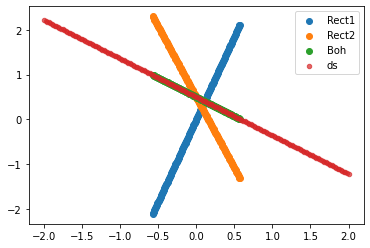

In [142]:
h_s = np.array([w1*x1 + w2*x2 + b0 for x1, x2 in ds])
rect1 = np.array([rect(h, w3, b1) for h in h_s])
rect2 = np.array([rect(h, w4, b2) for h in h_s])
rect_real = np.array([rect(h, m, q) for h in h_s])
plt.scatter(h_s, rect1, label="Rect1")
plt.scatter(h_s, rect2, label="Rect2")
plt.scatter(h_s, rect_real, label="Boh")
plot(ds, label="ds")
plt.legend()

In [128]:
import sympy as sp

syms = h, w_1, w_2, w_3, w_4, x, y, xhat, yhat, b_1, b_2, b_3 = sp.symbols("h, w_1, w_2, w_3, w_4, x, y, xhat, yhat b_1, b_2, b_3")

# h = w_1*x + w_2*y + b_1
# xhat = w_3*h + b_2
# yhat = w_4*h + b_3

In [130]:
h = w_1*(w_3*h + b_2) + w_2*(w_4*h + b_3) + b_1
sp.solve(h)

[{b_1: (-b_2*w_1**2*w_3 - b_2*w_1*w_2*w_4 - b_2*w_1 - b_3*w_1*w_2*w_3 - b_3*w_2**2*w_4 - b_3*w_2 - h*w_1**2*w_3**2 - 2*h*w_1*w_2*w_3*w_4 - h*w_2**2*w_4**2)/(w_1*w_3 + w_2*w_4 + 1)}]